# Tomatometer vs Audience score

Rotten tomatoes (RT) is a 'Review aggregation website' whose primary function is to rate movies and TV shows. Here professional critics review and rate the piece, and the website produces an aggregation of that score which they call the tomatometer. Rotten tomatoes also presents another score, the audience score, which is an aggregate of reviews by passionate movie viewers. Besides the famous review scores, Rotten tomatoes also contains information on cast, personal biographies, plot summaries, list posts as well as a podcast. The dataset was obtained of Kaggle: https://bit.ly/32Pf6Q6. I would like to compare the two sets of scores in few different ways:

1) Visualise the distributions of the two sets of scores in a simple histogram. 

2) We will be using a T-test to test if the difference in the means of the two sets of scores are statistically significant.

3) Visualise and compare the relative difference between the audience score and the tomatometer score for each movie. 

## Preparing the data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams['figure.figsize'] = [14, 10]
sns.set_style('white')

import warnings
warnings.filterwarnings(action = 'ignore')

In [4]:
# rotten tomatoes data
rt = pd.read_csv(r'C:\Users\harpo\Documents\Datasets\Movies\rotten_tomatoes_movies.csv')

#display(rt.head())

# reducing the dataset down to just the movie title, and the two scores
rt_ratings = rt[['movie_title', 'tomatometer_rating', 'audience_rating']]
rt_ratings.dropna(inplace=True)
rt_ratings['audience_rating'] = rt_ratings['audience_rating'].astype(int)

display(f'size of dataset: {len(rt_ratings)}')
display(rt_ratings.head())

'size of dataset: 16386'

,movie_title,tomatometer_rating,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,49,53
1,Please Give,86,64
2,10,68,53
3,12 Angry Men (Twelve Angry Men),100,97
4,"20,000 Leagues Under The Sea",89,74


# Plotting the distribution of the scores

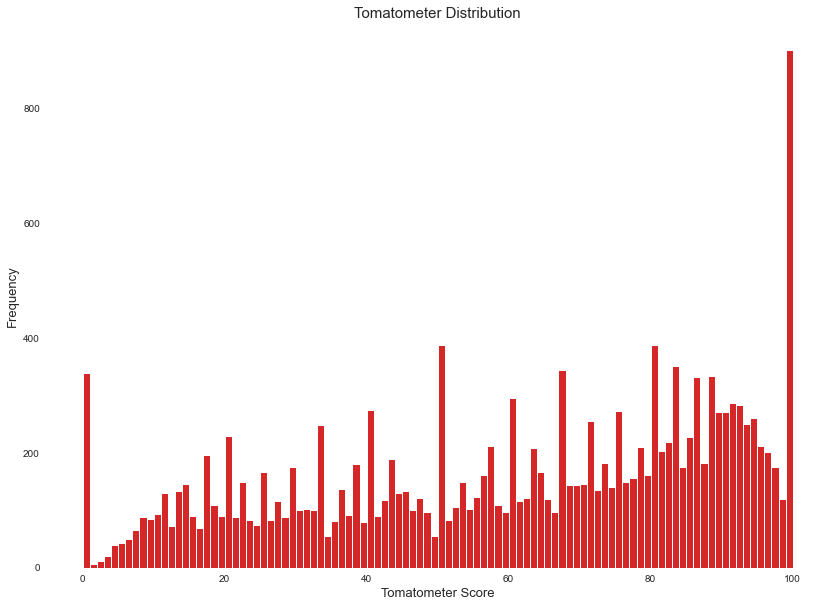

In [5]:
def distribution_plot(series, title, x_label, bar_color='tab:red'):
    """
    Creates a histogram of the input series with 100 bins. 
    
    Input:
    series - pandas series
    title - (string) title of histogram
    x_label - x-axis label
    bar_color - color of the bars in the histogram (default: 'tab: red')
    
    Output:
    Histogram of input series with 100 bins
    """
    series.sort_values().plot(kind='hist', bins=100, color=bar_color)
    sns.despine(bottom=True, left=True)
    plt.xlabel(x_label, fontsize=13)
    plt.ylabel('Frequency', fontsize=13)
    plt.title(title, fontsize=15)
    plt.show

# distribution of the tomatometer ratings
distribution_plot(rt_ratings['tomatometer_rating'], 
                  title='Tomatometer Distribution',
                  x_label='Tomatometer Score')

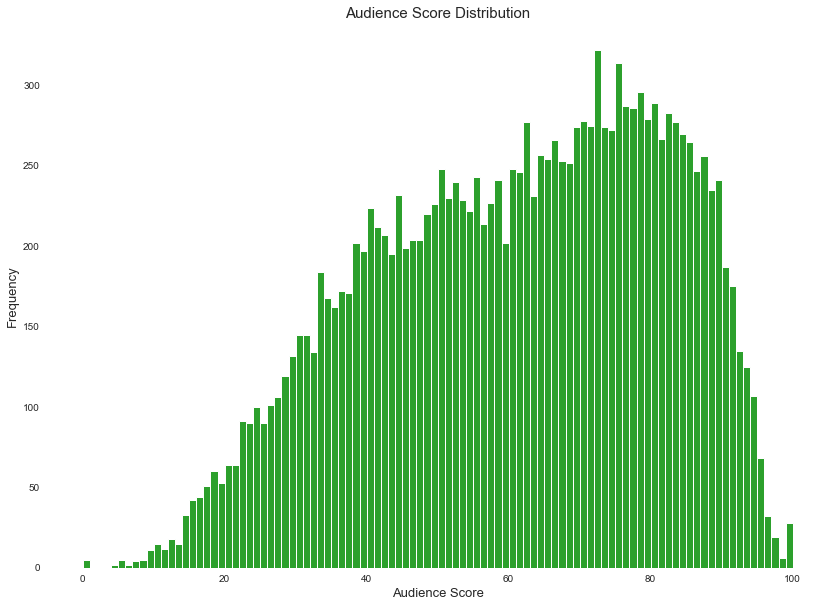

In [6]:
# distribution of the audience score
distribution_plot(rt_ratings['audience_rating'], 
                  title='Audience Score Distribution',
                  bar_color='tab:green',
                  x_label='Audience Score')

The audience score is far more normally distributed compared to the critics scores. This is very interesting, because it shows that there is more consensus between the audience compared to the critics.

I am not sure how appropriate it would be to do the statistical test to compare the two sample means, when one of the sets of data is not normally distributed, but we will find out how well the t-test preforms.

## Paired t-test

So the parameters is as follows:
- We have a large sample (n > 30).
- With continous variables needed to be tested (audience score and tomatometer score).
- We have two sets of paired samples, since each movie has a corresponding tomatometer score and an audience score. 
So we prefrom a <b>Paired t-test</b> from the scipy module.

### Hypothesis testing

Null hypothesis: The means are not different.

$$H_0 : \mu_t = \mu_a$$

Where $\mu_t$ is the tomatometer score mean, and $\mu_a$ is the audience score mean.

Alternative hypothesis: There is a difference between the means of the tomatometer and audience scores.

$$H_1 : \mu_t \neq \mu_a$$

We will pick the confidence interval at 95%.

$$\alpha = 0.05$$

In [7]:
from scipy import stats

test_statistic = stats.ttest_rel(rt_ratings['tomatometer_rating'], rt_ratings['audience_rating'])

display(test_statistic)

Ttest_relResult(statistic=-0.8492704023702629, pvalue=0.3957432542089552)

The result:
$$t = -0.849 $$
$$p = 0.396 $$

$p > \alpha$ Therefore we fail to reject the null hypothesis.

## Relative difference between scores

I want to calculate the difference between each pair of scores for each movie, we will call this the relative difference. We will create a new column and call it 'diff'. If:

$diff < 0$ -> RT Audience are more critical 

$diff > 0$ -> RT critics are more critical

$diff = 0$ -> RT critics and audience agree

We can visualise this in a stacked bar graph.


### Stacked bar graph of relative differences

In [8]:
rt_ratings['diff'] = rt_ratings['tomatometer_rating'] - rt_ratings['audience_rating']
rt_ratings

,movie_title,tomatometer_rating,audience_rating,diff
0,Percy Jackson & the Olympians: The Lightning T...,49,53,-4
1,Please Give,86,64,22
2,10,68,53,15
3,12 Angry Men (Twelve Angry Men),100,97,3
4,"20,000 Leagues Under The Sea",89,74,15
...,...,...,...,...
16633,Zoot Suit,56,74,-18
16634,Zootopia,97,92,5
16635,Zorba the Greek,78,87,-9
16636,Zulu,95,91,4


In [9]:
from collections import OrderedDict

def calc_perc(df, df2):
    """
    Takes in a dataframe and calculates the percentage of that dataframe compared to a larger dataframe
    
    Input:
    df - a dataframe
    df2 - a dataframe
    
    Output:
    the ratio of length between df and df2, mulpulied by 100.   
    """
    return (len(df) / len(df2)) * 100

def split_df_in3(df):
    '''
    splits the dataframe into 3 smaller dataframes, where the 'diff' values of the dataframe are negative,
    positive and equal
    
    input:
    df - dataframe to be split
    
    output:
    a - dataframe where 'diff' < 0
    b - dataframe where 'diff' > 0
    c - dataframe where 'diff' == 0
    '''
    a = df[df['diff'] < 0]
    b = df[df['diff'] > 0]
    c = df[df['diff'] == 0]
    return a, b, c


def stacked_bar(dic):
    '''
    Takes in a dictionary of proportions as keys paired a description as values and produces a stacked barchart.
    
    Input:
    dic - Dictionary with key = score, and value = string
    
    Ouptut:
    Plots a stacked barchart
    '''
    a, b, c = dic.keys()
    diff_df = pd.DataFrame({f"{a:.2f}%: " + dic[a] : [a], 
                        f"{b:.2f}%: " + dic[b]: [b] ,
                        f"{c:.2f}%: " + dic[c] : [c]}, 
                      index=[''])

    diff_df.plot(kind='barh', stacked=True, color=['tab:red', 'tab:green', 'tab:orange'])
    sns.despine(left=True, bottom=True)
    plt.legend(loc='upper center')
    plt.show()


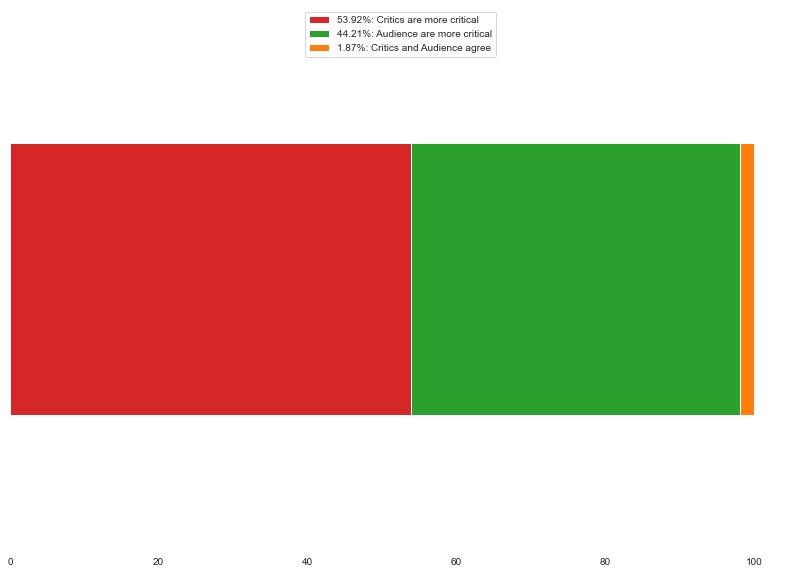

In [10]:
RT_df_lst = split_df_in3(rt_ratings)

# Finding the percentage of rt_ratings that 'diff' is negative, positive and equal to 0
RT_audience_score, RT_critics_score, critics_audience_agreed_score = [calc_perc(df=i, df2=rt_ratings)
                                                                         for i in RT_df_lst]

RT_crit_aud_dict = OrderedDict([
                                (RT_critics_score, "Critics are more critical"),
                                (RT_audience_score, "Audience are more critical"),
                                (critics_audience_agreed_score, "Critics and Audience agree")
                                ])

stacked_bar(RT_crit_aud_dict)

Not suprisingly the critics are more critical than the audience. Though the difference is not as stark as I would have thought it would be. It also seems that the critics and the audience perfectly agree a very small amount of the time. The distribution of the difference is a little less black and white then what is displayed in the stacked barchart. We can use a histogram to see if the critics and the audience somewhat agree overall by looking at the distribution of this relative difference between the scores.

### Histogram of relative differences

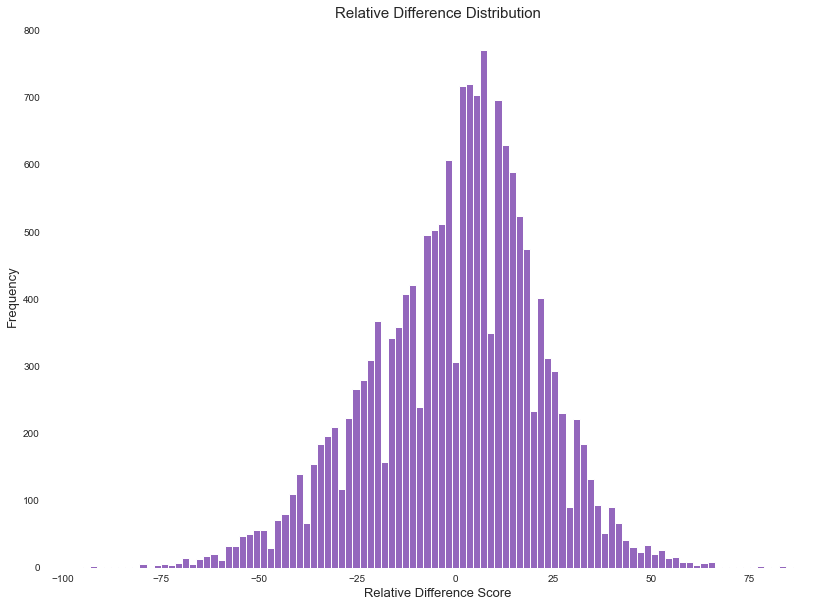

In [11]:
# distribution of the audience score
distribution_plot(rt_ratings['diff'], 
                  title='Relative Difference Distribution',
                  bar_color='tab:purple',
                  x_label='Relative Difference Score')

This distribution tends toward a normal distribution, where the audience and critcs tend to agree more often. The peak of the distribution is between 0 and 12. There is a secondary pattern I can see in the distribution, almost like an interference pattern, though I cannot figure out where that has come from. 

# Conclusion

From this analysis of tomatometer scores and audience score we can say that there was more consensus between the audience compared to the critics in general. We found using a t-test that the difference in the means was not statistically significant. However I am not sure how valid the t-test was because the audience scores do have a somewhat normal distribution, but the critics scores do not. We also had a look at the relative difference between the two sets of scores for the movies, and found that in general the critics are more critical. Looking at the distribution of the relative difference between the scores, we can see that the distribution is quite normal, signifying some consensus between the critics and the audience.

# References

[1] https://medium.com/python-in-plain-english/statistical-tests-with-python-880251e9b572 - To figure out what statisitcal test to do. Very helpful flowchart of statistical tests.